# Kaggle's  Bike Sharing Demand Dataset

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

## The Data:

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

### Data Fields:

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 
  * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

### Evaluation:

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE).

### Submission: 

Submission file must have a header and should be structured in the following format:

datetime,count

2011-01-20 00:00:00,0

2011-01-20 01:00:00,0

2011-01-20 02:00:00,0

...

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

In [27]:
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

In [28]:
print(train.shape)
train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [29]:
print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


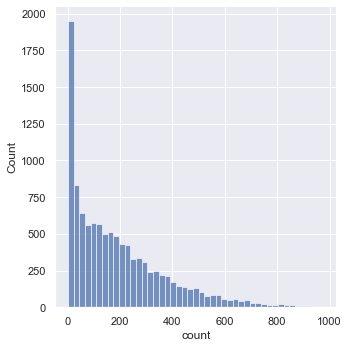

In [30]:
sns.displot(train, x="count")

<AxesSubplot:xlabel='count'>

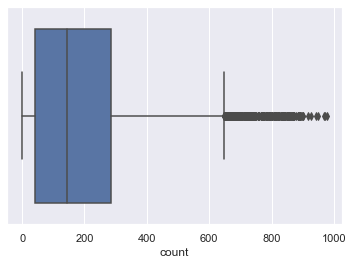

In [31]:
sns.boxplot(x = 'count', data = train, color = 'b')

In [32]:
Q1 = train['count'].quantile(0.25)
Q3 = train['count'].quantile(0.75)
IQR = Q3 - Q1
upper_outlier_threshold = Q3 + 1.5*IQR
print(f"There are {len(train[train['count'] >= upper_outlier_threshold])} outliers.")
train = train[train['count'] < upper_outlier_threshold]

There are 303 outliers.


<AxesSubplot:>

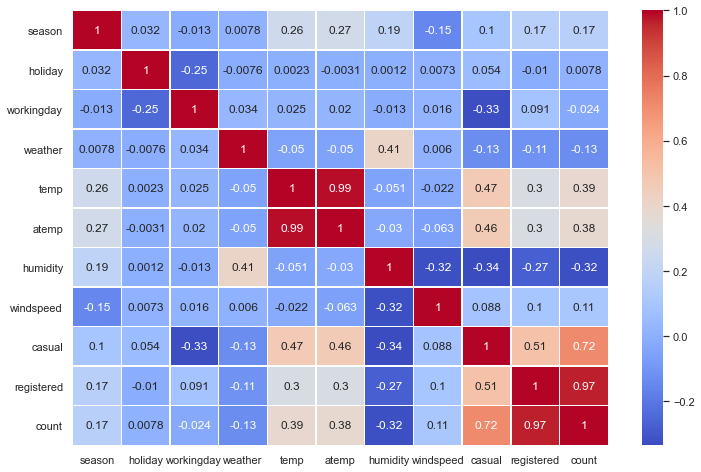

In [47]:
plt.figure(figsize = (12,8))
corr = train.corr()
sns.heatmap(corr, annot = True, cmap = 'coolwarm', linecolor = 'white', linewidths=0.4)

*temp* and *atemp* are the features that are more directly related with the labels (*casual*, *registered* and *count*), meaning that temperature has a role on whether people ride a bike or not. *temp* and *atemp* also have a strong correlation between them so in theory, one of them could be removed in order to simplify the predictive model.

### Feature Analysis

Text(0, 0.5, 'Average Count')

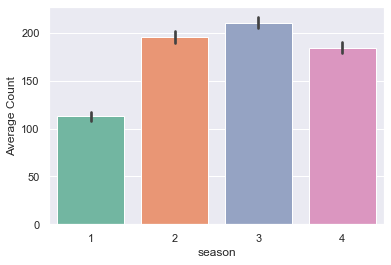

In [51]:
sns.barplot(x = 'season', y='count', data=train, palette='Set2')
plt.ylabel('Average Count')

Text(0, 0.5, 'Average Count')

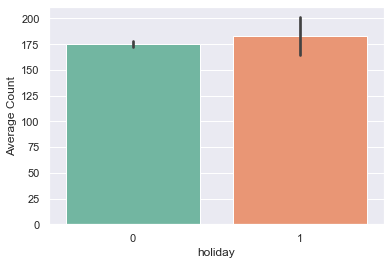

In [52]:
sns.barplot(x = 'holiday', y='count', data=train, palette='Set2')
plt.ylabel('Average Count')

Text(0, 0.5, 'Average Count')

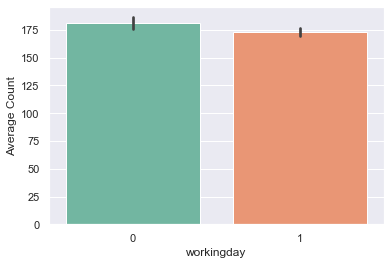

In [53]:
sns.barplot(x = 'workingday', y='count', data=train, palette='Set2')
plt.ylabel('Average Count')

Text(0, 0.5, 'Average Count')

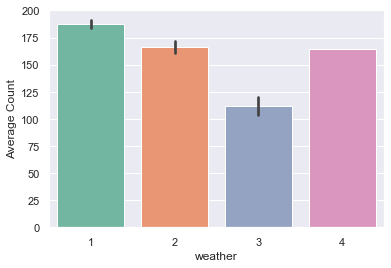

In [54]:
sns.barplot(x = 'weather', y='count', data=train, palette='Set2')
plt.ylabel('Average Count')

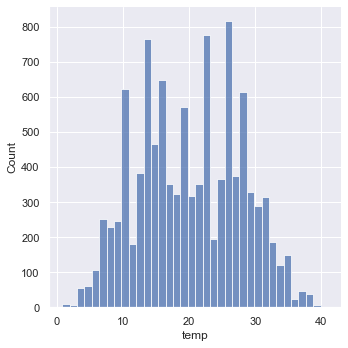

In [55]:
sns.displot(train, x="temp")

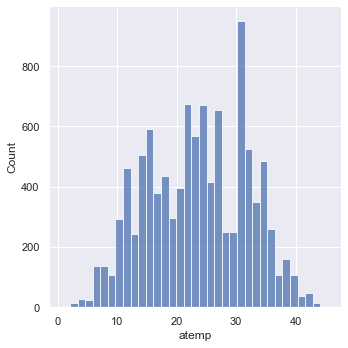

In [56]:
sns.displot(train, x="atemp")

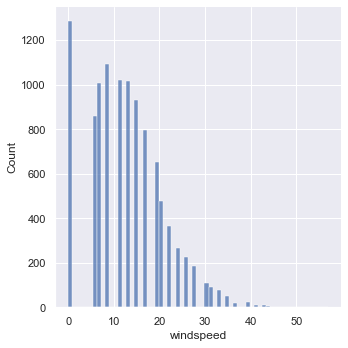

In [57]:
sns.displot(train, x="windspeed")

There a relevant percentage of data that as a windspeed of 0. We can see these values as missing values (a windspeed of 0 is unlikely) or just leave them as they are. In case of considering them as missing values, we could fill them as the average of the remaining wind speeds or consider them as low wind speeds, and in this case, fill them randomly with a number between 0 and the next minimum observed wind speed.

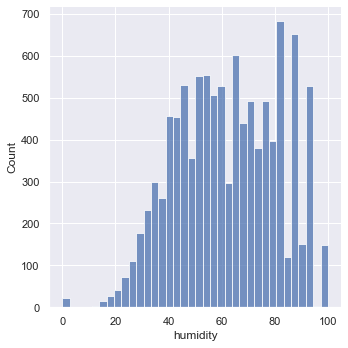

In [59]:
sns.displot(train, x="humidity")

In [60]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['hour'] = train['datetime'].apply(lambda x:x.hour)
train['month'] = train['datetime'].apply(lambda x:x.month)
train['day_of_week'] = train['datetime'].apply(lambda x:x.dayofweek)
# Since the training and testing data are from day 1 to 19 and from 20 to 31, 
# respectivelly, there is no point on descriminating the day distribution.

Text(0, 0.5, 'Average Count')

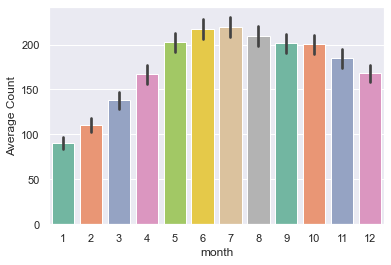

In [64]:
sns.barplot(x = 'month', y='count', data=train, palette='Set2')
plt.ylabel('Average Count')

Text(0, 0.5, 'Average Count')

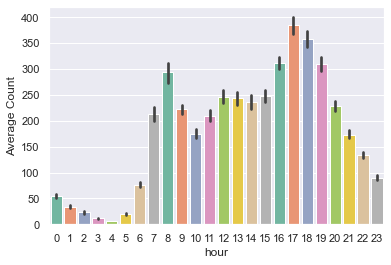

In [65]:
sns.barplot(x = 'hour', y='count', data=train, palette='Set2')
plt.ylabel('Average Count')

There is clearly a bigger usage during the daytime, with peaks during the rush hour (8 am and 5 pm). Since we see a skewed distribution towards the daytime, one possible option is to create a categorical feature representing whether or not is daytime.

Text(0, 0.5, 'Average Count')

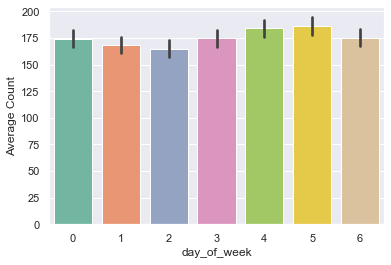

In [66]:
sns.barplot(x = 'day_of_week', y='count', data=train, palette='Set2')
plt.ylabel('Average Count')

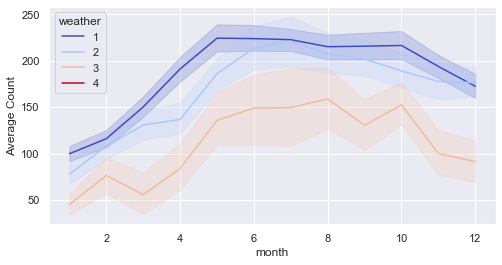

In [63]:
plt.figure(figsize = (8,4))
sns.lineplot(x = 'month', y = 'count', data = train, estimator = np.average, hue = 'weather', palette = 'coolwarm')
plt.ylabel('Average Count')
plt.show()

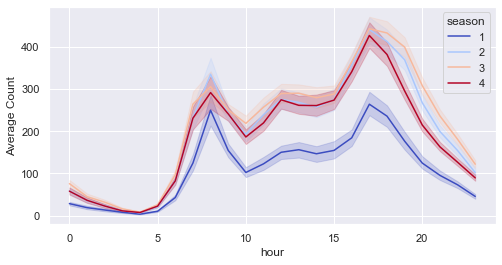

In [67]:
plt.figure(figsize = (8,4))
sns.lineplot(x = 'hour', y = 'count', data = train, estimator = np.average, hue = 'season', palette = 'coolwarm')
plt.ylabel('Average Count')
plt.show()

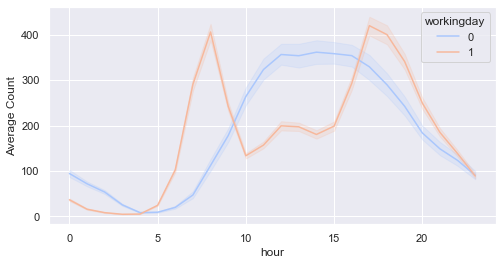

In [69]:
plt.figure(figsize = (8,4))
sns.lineplot(x = 'hour', y = 'count', data = train, estimator = np.average, hue = 'workingday', palette = 'coolwarm')
plt.ylabel('Average Count')
plt.show()

The peaks seen in rush hour are clearly associated with the working days. On the weekends there's a slower increase as the day progresses, with a max around 12am-3pm.

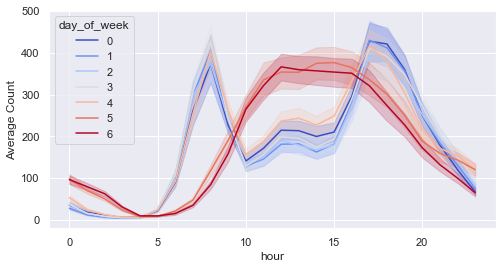

In [70]:
plt.figure(figsize = (8,4))
sns.lineplot(x = 'hour', y = 'count', data = train, estimator = np.average, hue = 'day_of_week', palette = 'coolwarm')
plt.ylabel('Average Count')
plt.show()

The days of the week follow a very similar distribution as the working days (which makes sense) so one of them may be discarded. 

In [75]:
train.to_csv('../data/interim/train.csv', index=False)